<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE


import pretrain
from pretrain import *

import Nets
from Nets import*

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

In [2]:
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)])
pregame.reset(set_agent=(2,2))
# rls_q = RLS(1)
# rls_sl = RLS(1)
# for i in range(1):
#     pregame.fulltrain(trials = 4)
    

In [3]:
game = ValueMaxGame(pregame.net, grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward =  [(0.5, 0.25), (0.5, 0.75)])
game.reset()
# game.experiment(rls_q, rls_sl, 20, epsilon = 0.5, lr = 1e-3, train_hidden = False, train_q = False) 

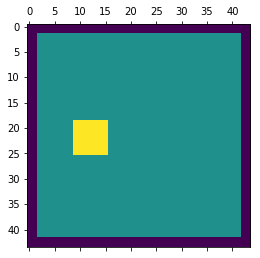

In [4]:
plt.matshow(game.grid.grid)
# plt.savefig('g16h3-map')

## Model Tranining 
Pretranining is done with fixed size 15,  training is between 10 to 15, test on 19 

Training from zero seems to be better because it will allow the agent to explore from new

In [6]:
for iters, noise in enumerate(6 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters, trial), rewards)

clear session data 49 2845798400
0 rewards 0.083221916971917
clear session data 49 2845798400
1 rewards 0.7079337194331117
clear session data 49 2845798400
2 rewards 0.7616159774135186
clear session data 49 2845798400
3 rewards 0.7991116955960706
clear session data 49 2845798400
4 rewards 0.6656408836959824
clear session data 49 2845798400
5 rewards 0.7453311557960405
clear session data 49 2845798400
6 rewards 0.566066053278829
clear session data 49 2845798400
7 rewards 0.5604295322328252
clear session data 49 2845798400
8 rewards 0.6859113474245053
clear session data 49 2845798400
9 rewards 0.742012934981685
clear session data 49 2845798400
10 rewards 0.7241978363072112
clear session data 49 2845798400
11 rewards 0.647302668029188
clear session data 49 2845798400
12 rewards 0.5766344848578147
clear session data 49 2845798400
13 rewards 0.7027503920006188
clear session data 49 2845798400
14 rewards 0.6565962230920768
clear session data 49 2845798400
15 rewards 0.6981724221958596
clear 

In [6]:
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+6)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+6, trial), rewards)

clear session data 49 3111833600
0 rewards 0.3999502149445101
clear session data 49 3111833600
1 rewards 0.5252749608587315
clear session data 49 3111833600
2 rewards 0.4749695114826694
clear session data 49 3111833600
3 rewards 0.4929316236681304
clear session data 49 3111833600
4 rewards 0.47591618450993445
clear session data 49 3111833600
5 rewards 0.46371843852986094
clear session data 49 3111833600
6 rewards 0.5849789762933144
clear session data 49 3111833600
7 rewards 0.49107088224275725
clear session data 49 3111833600
8 rewards 0.5339531477755679
clear session data 49 3111833600
9 rewards 0.6169878253929979
clear session data 49 3111833600
10 rewards 0.5154079980723301
clear session data 49 3111833600
11 rewards 0.5942660637973138
clear session data 49 3111833600
12 rewards 0.6052643505598669
clear session data 49 3111833600
13 rewards 0.6299902257404951
clear session data 49 3111833600
14 rewards 0.5251526917844149
clear session data 49 3111833600
15 rewards 0.4408680455144271

KeyboardInterrupt: 

In [ ]:
# add collision punishment
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+6)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+6, trial), rewards)

### measure decoding 

Decoding accuracy decreases, there are two possible reasons: 
1, decoding has bias,  information of position is only refleted by decoding, if there is certain bias , it is not trustable
2, it is the real measure of information, so there are less spatial information about space, or an effect decoupling/disentanglement of position. This can be due the network succeed at finding an even lower diemnsion object which gives successful performance.  The representation deceases its information to input in a sense. 

This can be linked to receptive field by looking at how space is represented. 

In [7]:
# dynamical lambda not alpha
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+9)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 10, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+9, trial), rewards)

clear session data 49 3433295872
0 rewards -0.33081906134586087
clear session data 49 3390676992
1 rewards -0.05595141882183907
clear session data 49 3390676992
2 rewards 0.21055151455744125
clear session data 49 3390676992
3 rewards 0.5135825477519557
clear session data 49 3390676992
4 rewards 0.9084560958971526
clear session data 49 3390676992
5 rewards 0.7912402701465202
clear session data 49 3390676992
6 rewards 0.7619081093992075
clear session data 49 3390676992
7 rewards 0.783366037143211
clear session data 49 3390676992
8 rewards 0.7204172445254629
clear session data 49 3390676992
9 rewards 0.8494295558646195


KeyboardInterrupt: 

In [8]:
# dynamical lambda not alpha, action changed no wall not fed back
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+10)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 10, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+10, trial), rewards)

clear session data 49 3629940736
0 rewards 0.46939569936492886
clear session data 49 3629940736
1 rewards 0.7426123992566707
clear session data 49 3629940736
2 rewards 0.7790225990510613
clear session data 49 3629940736
3 rewards 0.7850228432719242
clear session data 49 3629940736
4 rewards 0.7624041218423508
clear session data 49 3629940736
5 rewards 0.8200171476925793
clear session data 49 3629940736
6 rewards 0.7566214966502796
clear session data 49 3629940736
7 rewards 0.7118805933649683
clear session data 49 3629940736
8 rewards 0.631123380495783
clear session data 49 3629940736
9 rewards 0.5404808935277685
clear session data 49 3591143424
0 rewards 0.28290066555531707
clear session data 49 3591143424
1 rewards -0.640625


KeyboardInterrupt: 

In [2]:
# punish on the border , changed action not fedback
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+11)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 10, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+11, trial), rewards)

clear session data 49 2867220480
0 rewards 0.4387704060833173
clear session data 49 2867535872
1 rewards 0.7180914932670489
clear session data 49 2867535872
2 rewards 0.7162155507925982
clear session data 49 2867535872
3 rewards 0.7858049687276043
clear session data 49 2867535872
4 rewards 0.6900069319033665
clear session data 49 2867535872
5 rewards 0.6663131964145887
clear session data 49 2867535872
6 rewards 0.7408936633283238
clear session data 49 2867535872
7 rewards 0.6811684496059496
clear session data 49 2867535872
8 rewards 0.6268936336746284
clear session data 49 2867535872
9 rewards 0.6668250624313218
clear session data 49 2869669888
0 rewards 0.2662915148576913
clear session data 49 2869669888
1 rewards 0.8300123864982916
clear session data 49 2869669888
2 rewards 0.7655145648073989
clear session data 49 2869895168
3 rewards 0.8568235371314414
clear session data 49 2869895168
4 rewards 0.7868855536824286
clear session data 49 2869895168
5 rewards 0.8253021110833612
clear se

KeyboardInterrupt: 

In [3]:
# punish on the border , changed action not fedback, dynamical alpha 
for iters, noise in enumerate(5 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+13)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 10, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+13, trial), rewards)

clear session data 49 3310940160
0 rewards 0.3207760423056476
clear session data 49 3310940160
1 rewards 0.7458242713627543
clear session data 49 3310940160
2 rewards 0.7387079605021416
clear session data 49 3310940160
3 rewards 0.6179889268634999
clear session data 49 3310940160
4 rewards 0.7335096079066867
clear session data 49 3310940160
5 rewards 0.76000481000481
clear session data 49 3310940160
6 rewards 0.7052545746578613
clear session data 49 3310940160
7 rewards 0.6913075320643791
clear session data 49 3310940160
8 rewards 0.7051332794554301
clear session data 49 3310940160
9 rewards 0.7455490617599992
clear session data 49 3287216128
0 rewards 0.5285267504611935


KeyboardInterrupt: 

In [4]:
# punish on the border , changed action not fedback, dynamical alpha 
for iters, noise in enumerate(10 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+14)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 5, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+14, trial), rewards)

clear session data 49 3715334144
0 rewards 0.4740632005497023
clear session data 49 3715334144
1 rewards 0.6543910590616154
clear session data 49 3715334144
2 rewards 0.7363924472019838
clear session data 49 3715334144
3 rewards 0.7232335370446785
clear session data 49 3715334144
4 rewards 0.8193652815568934
clear session data 49 3715334144
0 rewards 0.16018463292311974
clear session data 49 3715334144
1 rewards 0.65208442602968
clear session data 49 3715334144
2 rewards 0.7578395160487903
clear session data 49 3715334144
3 rewards 0.7516291875908749
clear session data 49 3715334144
4 rewards 0.71738920220809
clear session data 49 3715334144
0 rewards 0.5328346467407179
clear session data 49 3715334144
1 rewards 0.5350667106902844
clear session data 49 3715334144
2 rewards 0.588742258898509
clear session data 49 3715334144
3 rewards 0.7648959418792276
clear session data 49 3715334144
4 rewards 0.743379407051282
clear session data 49 3676467200
0 rewards 0.2896330882122049
clear session

In [5]:
# punish on the border , changed action is fedback, dynamical alpha 
for iters, noise in enumerate(10 * [0.0]):
    for trial in [39]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+24)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 5, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters+24, trial), rewards)

clear session data 49 2870112256
0 rewards 0.4219898884306053
clear session data 49 2870374400
1 rewards 0.7051108714405108
clear session data 49 2870374400
2 rewards 0.6632439818323439
clear session data 49 2870374400
3 rewards 0.5668420368570293
clear session data 49 2870374400
4 rewards 0.7080936139427093
clear session data 49 2870374400
0 rewards 0.2689038825757576
clear session data 49 2870374400
1 rewards 0.6591888435638436
clear session data 49 2870374400
2 rewards 0.7952589721134129
clear session data 49 2870439936
3 rewards 0.7118715339854771
clear session data 49 2870439936
4 rewards 0.6780522624424583
clear session data 49 2870439936
0 rewards 0.421719749717372
clear session data 49 2870439936
1 rewards 0.6533666843968333
clear session data 49 2870439936
2 rewards 0.7155150249969329
clear session data 49 2870439936
3 rewards 0.7388958870589817
clear session data 49 2870439936
4 rewards 0.6587961877612365
clear session data 49 2870439936
0 rewards 0.5555466119120736
clear ses